In [ ]:
# todo
# triple QC plots against csv exports

In [1]:
# Load Dependencies

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Read in data and store them as a dictionary

file_names = [
    'merged_corr_df_.5s_epoch.csv',
    'merged_corr_df_1s_epoch.csv',
    'merged_corr_df_1.5s_epoch.csv',
    'merged_corr_df_2s_epoch.csv',
    'merged_corr_df_2.5s_epoch.csv',
    'merged_corr_df_3s_epoch.csv',
    'merged_corr_df_3.5s_epoch.csv',
    'merged_corr_df_4s_epoch.csv'
]

dataframes = {name: pd.read_csv(name) for name in file_names}


In [10]:
# Function to extract the epoch length from the filename
def extract_epoch_length(filename):
    # The regex looks for a potential leading dot (for .5s) and then digits
    match = re.search(r'_((?:\.\d+)|\d+(\.\d+)?)s_epoch', filename)
    if match:
        # If the match starts with a dot, prepend a 0, otherwise return the match as a float
        return float(match.group(1)) if not match.group(1).startswith('.') else float('0' + match.group(1))
    else:
        raise ValueError(f"Epoch length not found in file name: {filename}")

In [12]:
# Combine all files into one DataFrame with an additional 'Epoch' column

all_data = []
for file in file_names:
    df = pd.read_csv(file)
    epoch_length = extract_epoch_length(file)
    df['Epoch'] = epoch_length
    all_data.append(df)

In [14]:
# Concatenate all dataframes into one
combined_df = pd.concat(all_data)

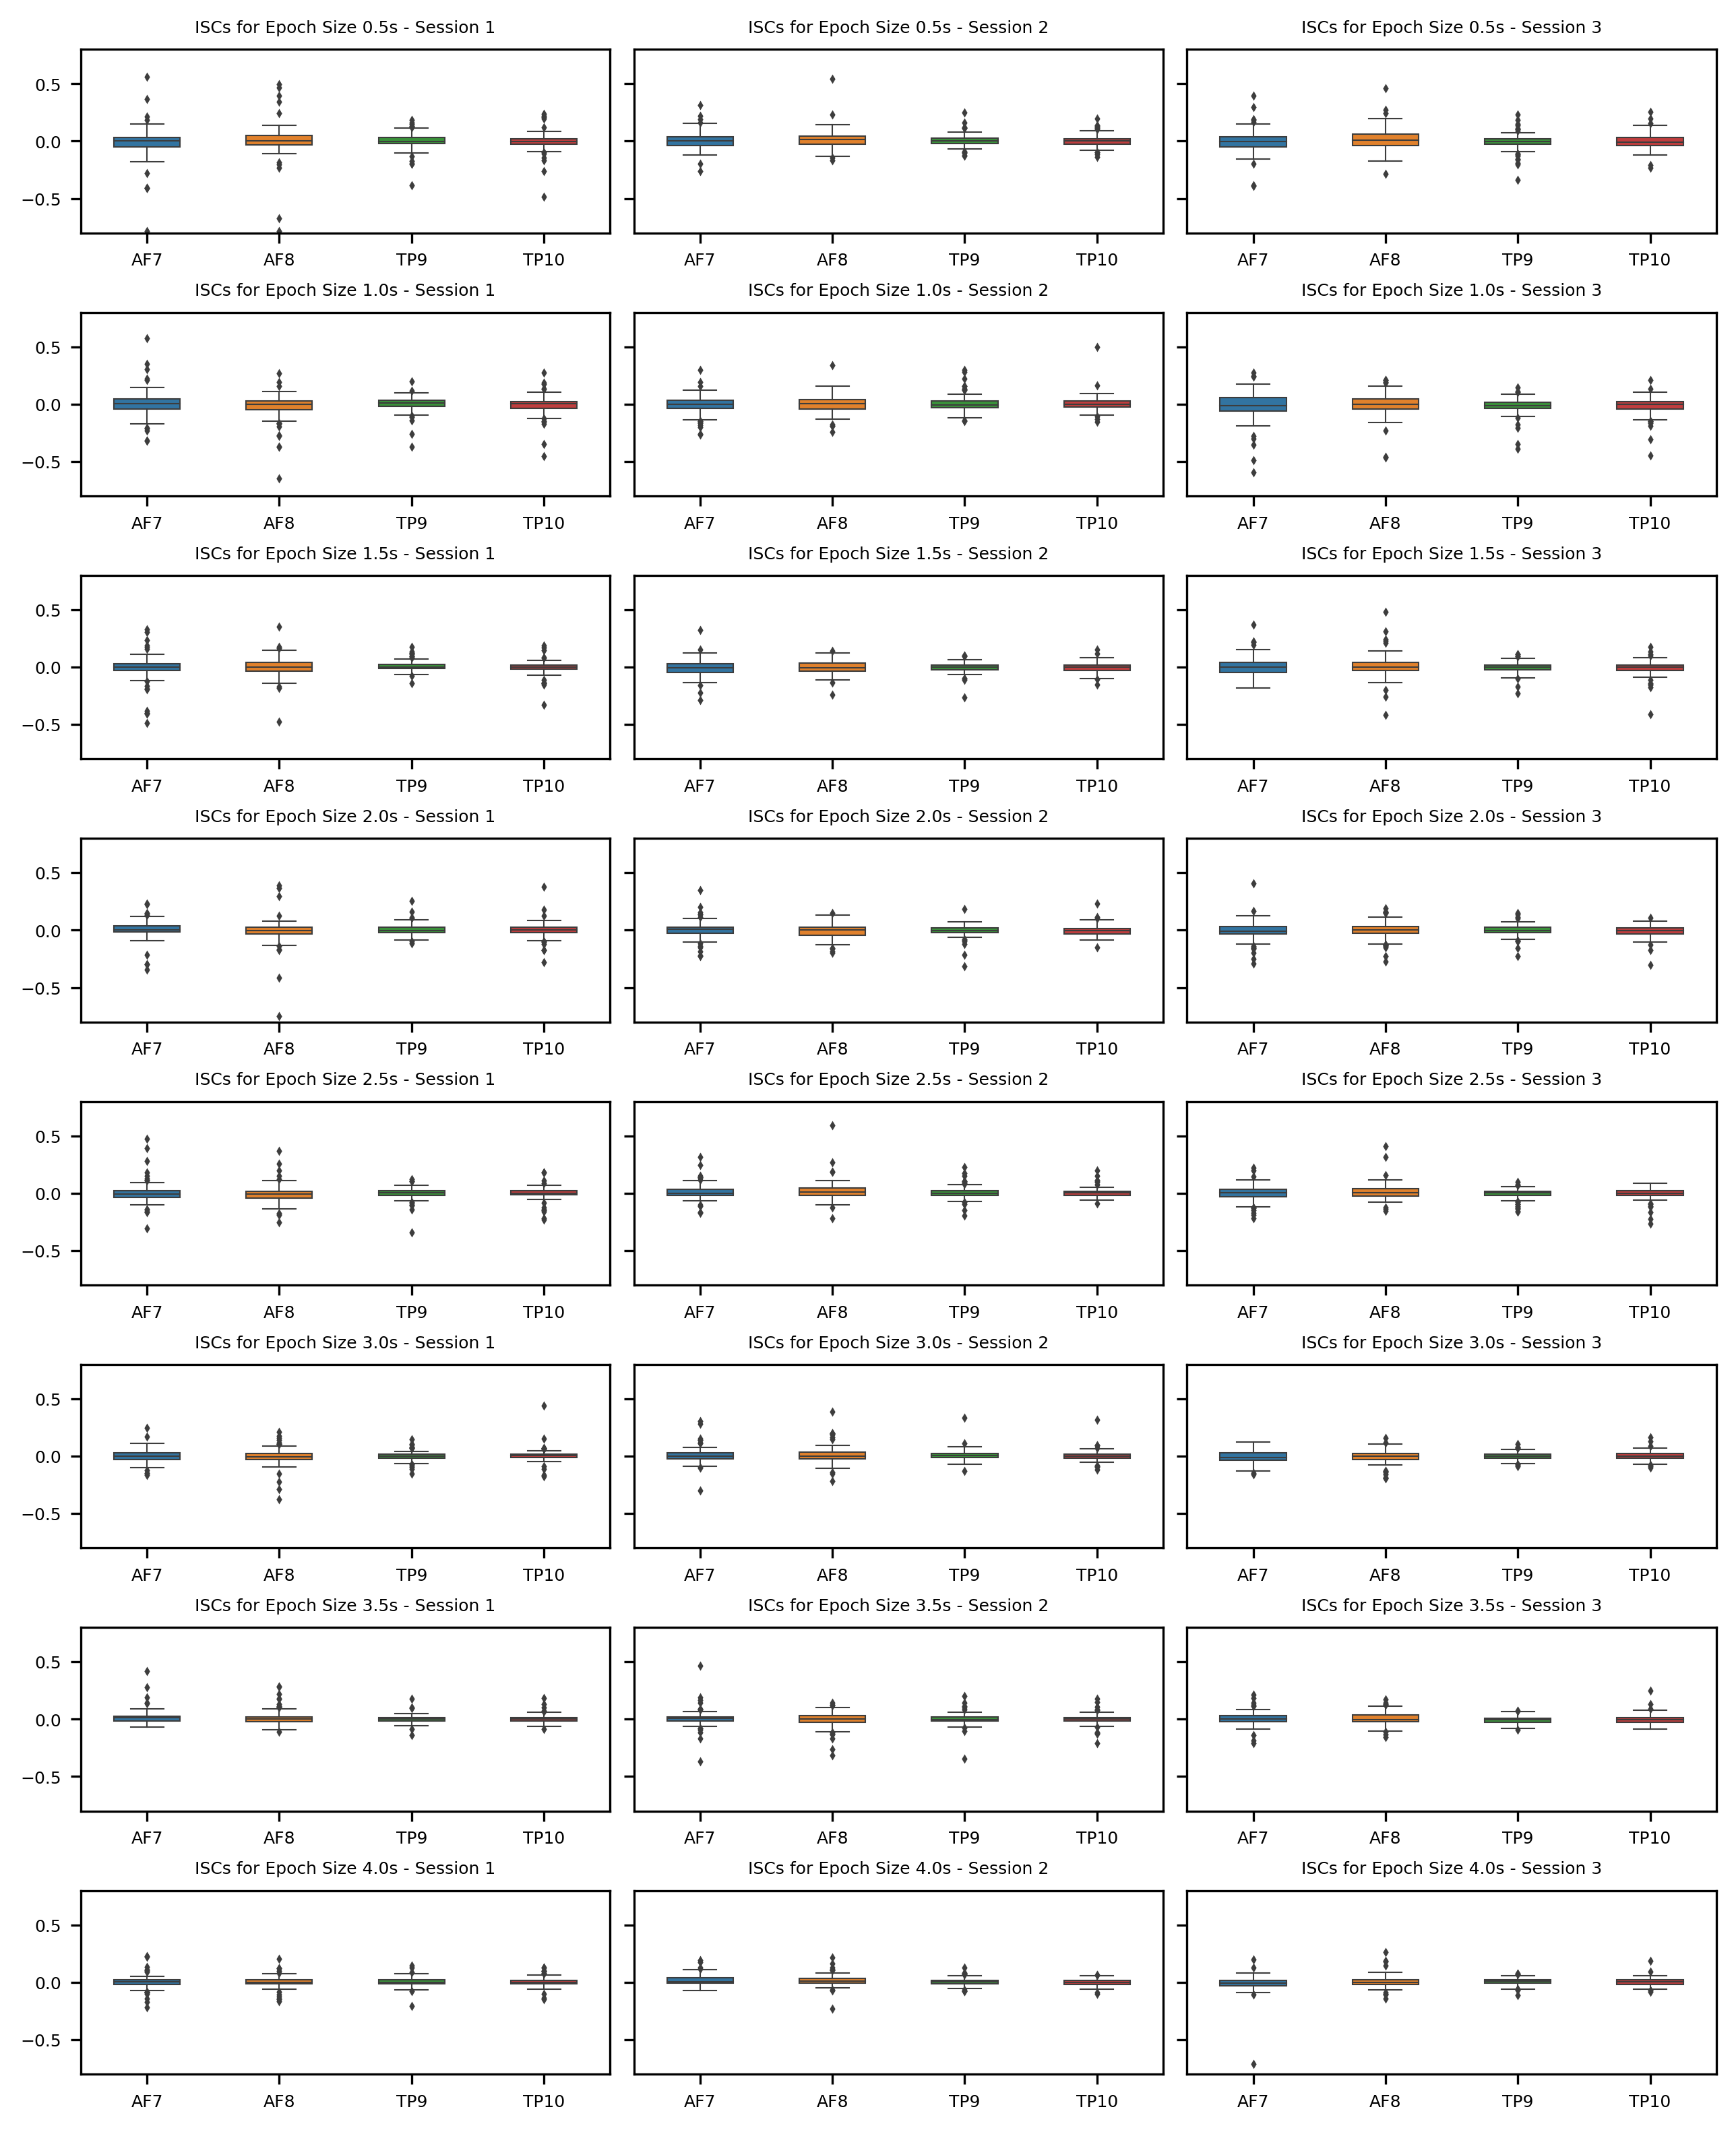

In [34]:
# Plot multiverse boxplot for ISCs by session


# Plot configuration (adjust these settings to get the plot to display the way you want)
small_font_size = 6  # Font size for axis labels and ticks
title_font_size = 6  # Font size font for subplot titles
fig_suptitle_font_size = 6  # Font size for the main title
line_width = 0.5  # Thinner lines for the boxplot
box_width = 0.5  # Narrower boxes
outlier_marker_size = 1.0  # Smaller size for the outlier markers

num_sessions = combined_df['ses'].nunique()
num_epochs = len(file_names)
fig, axes = plt.subplots(nrows=num_epochs, ncols=num_sessions, figsize=(8.5, 11), dpi=300, sharey=True)

# Set a main title for the plot
#fig.suptitle("Multiverse: ISC Boxplots", fontsize=fig_suptitle_font_size, y=0.99)

# Plot boxplots with customized aesthetics for outliers
for i, epoch in enumerate(sorted(combined_df['Epoch'].unique())):
    for j, session in enumerate(sorted(combined_df['ses'].unique())):
        ax = axes[i][j] if num_epochs > 1 else axes[j]
        epoch_data = combined_df[(combined_df['Epoch'] == epoch) & (combined_df['ses'] == session)]
        sns.boxplot(data=epoch_data[['AF7', 'AF8', 'TP9', 'TP10']], ax=ax, linewidth=line_width, width=box_width,
                    fliersize=outlier_marker_size)
        ax.set_ylim(-0.8, 0.8)  # Consistent y-axis scale for all boxplots
        ax.set_title(f'ISCs for Epoch Size {epoch}s - Session {session}', fontsize=title_font_size)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(labelsize=small_font_size)

# Reduce padding and adjust subplot spacing
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=0.4, h_pad=0.5, w_pad=0.5)

# Save the figure as a PNG file with a white background
plt.savefig('multiverse_isc_boxplots_final_adjusted.png', format='png', bbox_inches='tight', facecolor='white')

plt.show()

In [ ]:
# Storage for multiverse model summaries

param_estimates = pd.DataFrame()
p_values = pd.DataFrame()

In [ ]:
# Apply different filtering thresholds for correlation values (ranging from 0.1 to 1.0 in .1 increments)
# Then, for each filtered threshold, fit mixed models
# Then store parameter estimates and p-values in the new dataframes defined above

# Thresholds
thresholds = [x * 0.1 for x in range(1, 11)]  # 0.1 to 1.0 in increments of 0.1

for name, df in dataframes.items():
    for threshold in thresholds:
        filter_index = ((df[["TP10", "AF7", "AF8", "TP9"]] > threshold).any(1) | 
                        (df[["TP10", "AF7", "AF8", "TP9"]] < -threshold).any(1) | 
                        (df["Signal Drop"] == 1))
        filtered_df = df[~filter_index]

        # Loop through each electrode to fit a model
        for electrode in ['AF7', 'AF8', 'TP9', 'TP10']:
            model = smf.mixedlm(f"Performance ~ {electrode}", data=filtered_df, groups=filtered_df["subj"],
                                re_formula="1", vc_formula={"ses": "0 + C(ses)"})
            results = model.fit()

            # Store parameter estimates and p-values
            param_key = f"{name}_{threshold}_{electrode}"
            param_estimates.loc[param_key, 'Intercept'] = results.params['Intercept']
            param_estimates.loc[param_key, 'Electrode'] = electrode
            param_estimates.loc[param_key, 'Estimate'] = results.params[electrode]
            
            p_values.loc[param_key, 'Intercept_p'] = results.pvalues['Intercept']
            p_values.loc[param_key, 'Electrode'] = electrode
            p_values.loc[param_key, 'p_value'] = results.pvalues[electrode]

            # Print model summaries
            print(f"Results for {name}, Threshold {threshold}, Electrode {electrode}")
            print(results.summary())

In [ ]:
# Save the results dataframes to csv

param_estimates.to_csv("parameter_estimates.csv")
p_values.to_csv("p_values.csv")

In [ ]:
# Multiverse plot for AF7

# Regex to capture fractional seconds like .5s as 0.5
def extract_numeric_part(dataset_name):
    match = re.search(r'(\d+(\.\d+)?|\.5)s', dataset_name)
    if match:
        return float(match.group(1))
    return 0  # Default if no number found

# Extract datasets and thresholds
try:
    dataset_names = set('_'.join(idx.split('_')[:-2]) for idx in param_estimates.index)
    dataset_names = sorted(dataset_names, key=extract_numeric_part)
    thresholds = sorted(set(float(idx.split('_')[-2]) for idx in param_estimates.index))
except ValueError as e:
    print(f"Error parsing index: {e}")
    print("Sample problematic indices:", param_estimates.index[:5])

# Define a small font size for text (helps make plots bigger)
tiny_font_size = 6
smaller_font_size = 8  # For super title and column titles

fig, axes = plt.subplots(nrows=len(dataset_names), ncols=2, figsize=(8.5, 11), dpi=300)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Reduce the super title padding
fig.suptitle("Multiverse: AF7 Electrode", fontsize=smaller_font_size, va='bottom')

for i, dataset in enumerate(dataset_names):
    epoch_value = f"{extract_numeric_part(dataset)}s"
    for j, df in enumerate([param_estimates, p_values]):
        filtered_data = df[df['Electrode'] == 'AF7']
        filtered_data = filtered_data[filtered_data.index.str.contains(dataset)]
        filtered_data['Threshold'] = filtered_data.index.map(lambda x: float(x.split('_')[-2]))

        y_column = 'Estimate' if 'Estimate' in df.columns else 'p_value'
        ax = sns.lineplot(x='Threshold', y=y_column, data=filtered_data, ax=axes[i, j], marker='o')
        ax.set_title(f"Epoch {epoch_value}", fontsize=tiny_font_size, pad=3)
        ax.set_xlabel('Filter Threshold', fontsize=tiny_font_size)
        ax.set_ylabel(y_column, fontsize=tiny_font_size)
        ax.tick_params(labelsize=tiny_font_size)

        if j == 1:  # P-value column specific adjustments
            ax.set_ylim(0, 1)
            ax.axhline(0.05, color='red', linestyle='--')

# Set column titles above the columns, outside the plots
axes[0, 0].set_title("Parameter Estimate", fontsize=smaller_font_size, pad=20)
axes[0, 1].set_title("P-Value", fontsize=smaller_font_size, pad=20)

# Tighten the layout with reduced padding for super title
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Saving the figure with adjusted parameters
plt.savefig('parameter_estimates_and_p_values_af7.png', 
            format='png', 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')
plt.show()

In [ ]:
# Multiverse plot for AF8

# Regex to capture fractional seconds like .5s as 0.5
def extract_numeric_part(dataset_name):
    match = re.search(r'(\d+(\.\d+)?|\.5)s', dataset_name)
    if match:
        return float(match.group(1))
    return 0  # Default if no number found

# Extract datasets and thresholds
try:
    dataset_names = set('_'.join(idx.split('_')[:-2]) for idx in param_estimates.index)
    dataset_names = sorted(dataset_names, key=extract_numeric_part)
    thresholds = sorted(set(float(idx.split('_')[-2]) for idx in param_estimates.index))
except ValueError as e:
    print(f"Error parsing index: {e}")
    print("Sample problematic indices:", param_estimates.index[:5])

# Define a small font size for text (helps make plots bigger)
tiny_font_size = 6
smaller_font_size = 8  # For super title and column titles

fig, axes = plt.subplots(nrows=len(dataset_names), ncols=2, figsize=(8.5, 11), dpi=300)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Reduce the super title padding
fig.suptitle("Multiverse: AF8 Electrode", fontsize=smaller_font_size, va='bottom')

for i, dataset in enumerate(dataset_names):
    epoch_value = f"{extract_numeric_part(dataset)}s"
    for j, df in enumerate([param_estimates, p_values]):
        filtered_data = df[df['Electrode'] == 'AF8']
        filtered_data = filtered_data[filtered_data.index.str.contains(dataset)]
        filtered_data['Threshold'] = filtered_data.index.map(lambda x: float(x.split('_')[-2]))

        y_column = 'Estimate' if 'Estimate' in df.columns else 'p_value'
        ax = sns.lineplot(x='Threshold', y=y_column, data=filtered_data, ax=axes[i, j], marker='o')
        ax.set_title(f"Epoch {epoch_value}", fontsize=tiny_font_size, pad=3)
        ax.set_xlabel('Filter Threshold', fontsize=tiny_font_size)
        ax.set_ylabel(y_column, fontsize=tiny_font_size)
        ax.tick_params(labelsize=tiny_font_size)

        if j == 1:  # P-value column specific adjustments
            ax.set_ylim(0, 1)
            ax.axhline(0.05, color='red', linestyle='--')

# Set column titles above the columns, outside the plots
axes[0, 0].set_title("Parameter Estimate", fontsize=smaller_font_size, pad=20)
axes[0, 1].set_title("P-Value", fontsize=smaller_font_size, pad=20)

# Tighten the layout with reduced padding for super title
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Saving the figure with adjusted parameters
plt.savefig('parameter_estimates_and_p_values_af8.png', 
            format='png', 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')
plt.show()

In [ ]:
# Multiverse plot for TP9

# Regex to capture fractional seconds like .5s as 0.5
def extract_numeric_part(dataset_name):
    match = re.search(r'(\d+(\.\d+)?|\.5)s', dataset_name)
    if match:
        return float(match.group(1))
    return 0  # Default if no number found

# Extract datasets and thresholds
try:
    dataset_names = set('_'.join(idx.split('_')[:-2]) for idx in param_estimates.index)
    dataset_names = sorted(dataset_names, key=extract_numeric_part)
    thresholds = sorted(set(float(idx.split('_')[-2]) for idx in param_estimates.index))
except ValueError as e:
    print(f"Error parsing index: {e}")
    print("Sample problematic indices:", param_estimates.index[:5])

# Define a small font size for text (helps make plots bigger)
tiny_font_size = 6
smaller_font_size = 8  # For super title and column titles

fig, axes = plt.subplots(nrows=len(dataset_names), ncols=2, figsize=(8.5, 11), dpi=300)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Reduce the super title padding
fig.suptitle("Multiverse: TP9 Electrode", fontsize=smaller_font_size, va='bottom')

for i, dataset in enumerate(dataset_names):
    epoch_value = f"{extract_numeric_part(dataset)}s"
    for j, df in enumerate([param_estimates, p_values]):
        filtered_data = df[df['Electrode'] == 'TP9']
        filtered_data = filtered_data[filtered_data.index.str.contains(dataset)]
        filtered_data['Threshold'] = filtered_data.index.map(lambda x: float(x.split('_')[-2]))

        y_column = 'Estimate' if 'Estimate' in df.columns else 'p_value'
        ax = sns.lineplot(x='Threshold', y=y_column, data=filtered_data, ax=axes[i, j], marker='o')
        ax.set_title(f"Epoch {epoch_value}", fontsize=tiny_font_size, pad=3)
        ax.set_xlabel('Filter Threshold', fontsize=tiny_font_size)
        ax.set_ylabel(y_column, fontsize=tiny_font_size)
        ax.tick_params(labelsize=tiny_font_size)

        if j == 1:  # P-value column specific adjustments
            ax.set_ylim(0, 1)
            ax.axhline(0.05, color='red', linestyle='--')

# Set column titles above the columns, outside the plots
axes[0, 0].set_title("Parameter Estimate", fontsize=smaller_font_size, pad=20)
axes[0, 1].set_title("P-Value", fontsize=smaller_font_size, pad=20)

# Tighten the layout with reduced padding for super title
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Saving the figure with adjusted parameters
plt.savefig('parameter_estimates_and_p_values_tp9.png', 
            format='png', 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')
plt.show()

In [ ]:
# Multiverse plot for TP10

# Regex to capture fractional seconds like .5s as 0.5
def extract_numeric_part(dataset_name):
    match = re.search(r'(\d+(\.\d+)?|\.5)s', dataset_name)
    if match:
        return float(match.group(1))
    return 0  # Default if no number found

# Extract datasets and thresholds
try:
    dataset_names = set('_'.join(idx.split('_')[:-2]) for idx in param_estimates.index)
    dataset_names = sorted(dataset_names, key=extract_numeric_part)
    thresholds = sorted(set(float(idx.split('_')[-2]) for idx in param_estimates.index))
except ValueError as e:
    print(f"Error parsing index: {e}")
    print("Sample problematic indices:", param_estimates.index[:5])

# Define a small font size for text (helps make plots bigger)
tiny_font_size = 6
smaller_font_size = 8  # For super title and column titles

fig, axes = plt.subplots(nrows=len(dataset_names), ncols=2, figsize=(8.5, 11), dpi=300)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Reduce the super title padding
fig.suptitle("Multiverse: TP10 Electrode", fontsize=smaller_font_size, va='bottom')

for i, dataset in enumerate(dataset_names):
    epoch_value = f"{extract_numeric_part(dataset)}s"
    for j, df in enumerate([param_estimates, p_values]):
        filtered_data = df[df['Electrode'] == 'TP10']
        filtered_data = filtered_data[filtered_data.index.str.contains(dataset)]
        filtered_data['Threshold'] = filtered_data.index.map(lambda x: float(x.split('_')[-2]))

        y_column = 'Estimate' if 'Estimate' in df.columns else 'p_value'
        ax = sns.lineplot(x='Threshold', y=y_column, data=filtered_data, ax=axes[i, j], marker='o')
        ax.set_title(f"Epoch {epoch_value}", fontsize=tiny_font_size, pad=3)
        ax.set_xlabel('Filter Threshold', fontsize=tiny_font_size)
        ax.set_ylabel(y_column, fontsize=tiny_font_size)
        ax.tick_params(labelsize=tiny_font_size)

        if j == 1:  # P-value column specific adjustments
            ax.set_ylim(0, 1)
            ax.axhline(0.05, color='red', linestyle='--')

# Set column titles above the columns, outside the plots
axes[0, 0].set_title("Parameter Estimate", fontsize=smaller_font_size, pad=20)
axes[0, 1].set_title("P-Value", fontsize=smaller_font_size, pad=20)

# Tighten the layout with reduced padding for super title
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Saving the figure with adjusted parameters
plt.savefig('parameter_estimates_and_p_values_tp10.png', 
            format='png', 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')
plt.show()